## Required packages

In [ ]:
import os
import sys
import joblib

import numpy as np
import pandas as pd
from collections import Counter
import miceforest as mf
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    recall_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score
)
from sklearn.model_selection import (
    train_test_split,
    GroupShuffleSplit,
    GroupKFold,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

d:\Anaconda3\envs\oldml39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset & Data preprocessing

In [ ]:
df = pd.read_csv(r'C:\Users\Administrator\Desktop\data.csv')
y  = df['Early_ADHD']

categorical_cols = [
        'Race','Household income quintiles','Low weight','Premature','Gender','Prenatal non-trivial infections',
        'Regular eat','Prenatal drinking','Postpartum depression','Prenatal depression','Prenatal eclampsia','Prenatal epilepsy',
        'Prenatal persistent vomiting','Regular bedtimes','Media','Single parent','Prenatal Suspected Slow Growth','Multiple pregnancy',
        'Threatened miscarriage','Prenatal asthma','Secondhand smoke','Mothers academic qualification','Age group',
        'Prenatal smoking','Breastfeeding','Suspected social delay','Suspected fine motor delay','Suspected gross motor delay'
    ]
multi_class_cols = ['Race','Age group']
ordinal_cols     = ['Household income quintiles','Prenatal drinking','Regular bedtimes','Media','Mothers academic qualification','Regular eat']
binary_cols      = [c for c in categorical_cols if c not in multi_class_cols + ordinal_cols]
val_cols = [
        'Prepregnancy BMI','Independence-Self Regulation','Naming vocabulary','Emotional Symptoms','Conduct problems','Peer problems','Prosocial Behaviour',
        'Mother-child Conflicts','Injury','Mother-child positive relationship','Mood','Approach','Adaptability','Regularity','Emotional-Dysregulation','School readiness composit','Cry'
    ]

df_src = df[multi_class_cols + ordinal_cols + binary_cols + val_cols].copy()
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_ohe = pd.DataFrame(
        ohe.fit_transform(df_src[multi_class_cols]),
        columns=ohe.get_feature_names_out(multi_class_cols),
        index=df_src.index
    )
ord_enc = OrdinalEncoder()
X_ord = pd.DataFrame(
        ord_enc.fit_transform(df_src[ordinal_cols]),
        columns=ordinal_cols, index=df_src.index
    )
X_rest = pd.concat([df_src[binary_cols], X_ord, X_ohe], axis=1)
X = pd.concat([X_rest, df_src[val_cols]], axis=1)

kernel = mf.ImputationKernel(
    data=X,
    num_datasets=1,                 
    save_all_iterations_data=True,  
    random_state=0
)
kernel.mice(10)
X_imputed = kernel.complete_data()  

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train.loc[:, val_cols] = scaler.fit_transform(X_train[val_cols])
X_test.loc[:,  val_cols] = scaler.transform(  X_test[val_cols])

classes        = np.unique(y_train)
weights        = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights  = dict(zip(classes, weights))

orig_counts    = {c: np.sum(y_train == c) for c in classes}
neg_label, pos_label = sorted(orig_counts, key=lambda c: orig_counts[c])
scale_pos_weight    = orig_counts[neg_label] / orig_counts[pos_label]

test_weights = df.loc[X_test.index, 'DOVWT2']
class_w = y_test.map(class_weights).fillna(1.0)
comp_w  = test_weights * class_w

rus = RandomUnderSampler(sampling_strategy=0.2, random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

## Six Machine Learning Training Pipelines: RFE + Hyperparameter tuning

In [ ]:
# Hyperparameter tuning
models = {
    'RandomForest': RandomForestClassifier(
        random_state=42, class_weight=class_weights, n_jobs=1
    ),
    'SVM': SVC(
        kernel='rbf', probability=True, random_state=42, class_weight=class_weights
    ),
    'LightGBM': LGBMClassifier(
        random_state=42, class_weight=class_weights, n_jobs=1
    ),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        n_jobs=1
    ),
    'MLP': MLPClassifier(random_state=42),
}

param_grid = {
    'RandomForest': {
        'n_estimators': [400, 600, 800, 1000],
        'max_depth': [None, 20, 40, 60],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False],
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 1e-2, 1e-1],
        'tol': [1e-3, 1e-4],
        'class_weight': [class_weights, 'balanced'],
    },
    'LightGBM': {
        'n_estimators': [400, 800, 1200],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [31, 63, 127],
        'max_depth': [-1, 10, 20],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0.0, 0.1],
    },
    'KNN': {
        'n_neighbors': list(range(3, 23, 2)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
        'leaf_size': [20, 40],
        'algorithm': ['auto', 'kd_tree', 'ball_tree'],
    },
    'XGBoost': {
        'n_estimators': [600, 900, 1200],
        'learning_rate': [0.01, 0.05],
        'max_depth': [6, 8, 10],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0.0, 0.1],
        'reg_alpha': [0.0, 0.1],
        'reg_lambda': [1, 3],
    },
    'MLP': {
        'hidden_layer_sizes': [
            (64,), (128,), (256,),
            (128, 64), (256, 128), (256, 128, 64),
        ],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
        'learning_rate_init': [1e-4, 1e-3, 5e-3],
        'batch_size': ['auto', 64, 128],
    },
}

# Pipeline: RFE + GridSearchCV
cv = GroupKFold(n_splits=5)

scoring = {
    'Macro_Recall': make_scorer(recall_score, average='macro'),
    'Macro_F1': make_scorer(f1_score, average='macro'),
}

total_feats = X_res.shape[1]
candidate_ns = list(range(15, total_feats // 2 + 1, 7))
rfe_step = 0.1

final_models = {}

for name, model in models.items():
    print(f"\n→ RFE+GridSearch on {name}")

    if name in ['SVM', 'KNN', 'MLP']:
        rfe_est = LinearSVC(
            dual=False,
            max_iter=5000,
            random_state=42,
            class_weight=class_weights,
        )
        imp_getter = 'auto'
    else:
        rfe_est = clone(model)
        imp_getter = 'auto'

    pipe = Pipeline(
        steps=[
            (
                'feature_selection',
                RFE(
                    estimator=rfe_est,
                    n_features_to_select=None,
                    step=rfe_step,
                    importance_getter=imp_getter,
                ),
            ),
            ('classifier', clone(model)),
        ]
    )

    grid_pipe = {
        'feature_selection__n_features_to_select': candidate_ns,
        **{f'classifier__{k}': v for k, v in param_grid[name].items()},
    }

    search = GridSearchCV(
        estimator=pipe,
        param_grid=grid_pipe,
        scoring=scoring,
        refit='Macro_Recall',
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )

    groups_res = df.loc[X_res.index, 'SPTN00']
    search.fit(X_res, y_res, groups=groups_res)

    best_pipe = search.best_estimator_
    chosen_k = best_pipe.named_steps['feature_selection'].n_features_
    final_models[name] = best_pipe

## Test set results

[LightGBM] [Info] Number of positive: 163, number of negative: 814
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 977, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876042 -> initscore=1.955469
[LightGBM] [Info] Start training from score 1.955469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

d:\Anaconda3\envs\oldml39\lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Anaconda3\envs\oldml39\lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Anaconda3\envs\oldml39\lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Anaconda3\envs\oldml39\lib\site-packa


===== Threshold method: YOUDEN =====
RandomForest best threshold = 0.3000, Youden = 0.9039
SVM best threshold = 0.1800, Youden = 0.5204
LightGBM best threshold = 0.3600, Youden = 0.9547
KNN best threshold = 0.1300, Youden = 0.5713
XGBoost best threshold = 0.1300, Youden = 0.6110
MLP best threshold = 0.1300, Youden = 0.5867

=== RandomForest (YOUDEN threshold = 0.3000) ===
Train Accuracy: 0.934622467771639
Test  Accuracy: 0.7917614232719246
   macro | Spec: 0.9270 | Prec: 0.5963 | Rec: 0.7904 | F1: 0.6336
   micro | Spec: 0.9270 | Prec: 0.9194 | Rec: 0.9194 | F1: 0.9194
weighted | Spec: 0.9203 | Prec: 0.8180 | Rec: 0.7918 | F1: 0.7901

Confusion Matrix (%):
        Pred 0  Pred 1
True 0   92.03    7.97
True 1   31.89   68.11


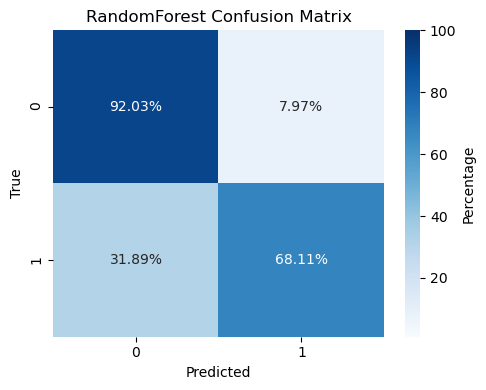


=== SVM (YOUDEN threshold = 0.1800) ===
Train Accuracy: 0.7882136279926335
Test  Accuracy: 0.7953525737854081
   macro | Spec: 0.8327 | Prec: 0.5540 | Rec: 0.8010 | F1: 0.5534
   micro | Spec: 0.8327 | Prec: 0.8310 | Rec: 0.8310 | F1: 0.8310
weighted | Spec: 0.8128 | Prec: 0.7975 | Rec: 0.7954 | F1: 0.7956

Confusion Matrix (%):
        Pred 0  Pred 1
True 0   81.28   18.72
True 1   21.97   78.03


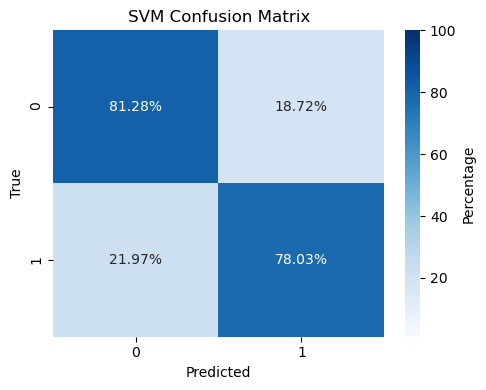


=== LightGBM (YOUDEN threshold = 0.3600) ===
Train Accuracy: 0.9659300184162063
Test  Accuracy: 0.708698467723086
   macro | Spec: 0.9383 | Prec: 0.5884 | Rec: 0.7255 | F1: 0.6200
   micro | Spec: 0.9383 | Prec: 0.9265 | Rec: 0.9265 | F1: 0.9265
weighted | Spec: 0.9367 | Prec: 0.7740 | Rec: 0.7087 | F1: 0.6977

Confusion Matrix (%):
        Pred 0  Pred 1
True 0   93.67    6.33
True 1   48.77   51.23


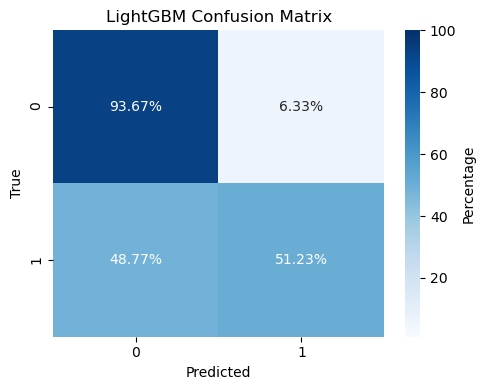


=== KNN (YOUDEN threshold = 0.1300) ===
Train Accuracy: 0.7716390423572744
Test  Accuracy: 0.7763425311567308
   macro | Spec: 0.7779 | Prec: 0.5398 | Rec: 0.7672 | F1: 0.5150
   micro | Spec: 0.7779 | Prec: 0.7773 | Rec: 0.7773 | F1: 0.7773
weighted | Spec: 0.7651 | Prec: 0.7766 | Rec: 0.7763 | F1: 0.7764

Confusion Matrix (%):
        Pred 0  Pred 1
True 0   76.51   23.49
True 1   21.40   78.60


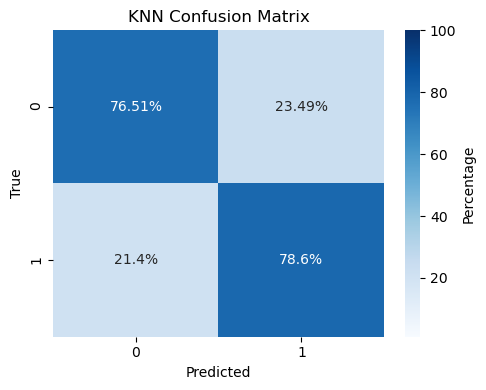


=== XGBoost (YOUDEN threshold = 0.1300) ===
Train Accuracy: 0.8453038674033149
Test  Accuracy: 0.8125395657315228
   macro | Spec: 0.8795 | Prec: 0.5667 | Rec: 0.7923 | F1: 0.5846
   micro | Spec: 0.8795 | Prec: 0.8746 | Rec: 0.8746 | F1: 0.8746
weighted | Spec: 0.8704 | Prec: 0.8201 | Rec: 0.8125 | F1: 0.8126

Confusion Matrix (%):
        Pred 0  Pred 1
True 0   87.04   12.96
True 1   23.73   76.27


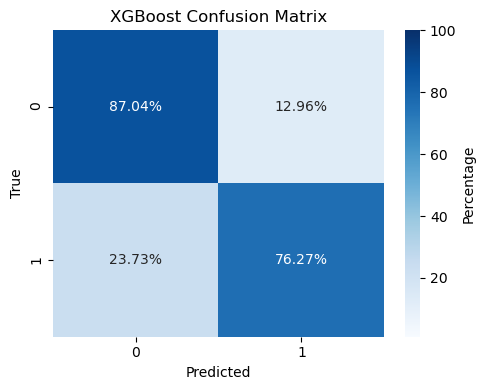


=== MLP (YOUDEN threshold = 0.1300) ===
Train Accuracy: 0.7845303867403315
Test  Accuracy: 0.7944809753712452
   macro | Spec: 0.7893 | Prec: 0.5458 | Rec: 0.7985 | F1: 0.5275
   micro | Spec: 0.7893 | Prec: 0.7898 | Rec: 0.7898 | F1: 0.7898
weighted | Spec: 0.7708 | Prec: 0.7943 | Rec: 0.7945 | F1: 0.7944

Confusion Matrix (%):
        Pred 0  Pred 1
True 0   77.08   22.92
True 1   18.52   81.48


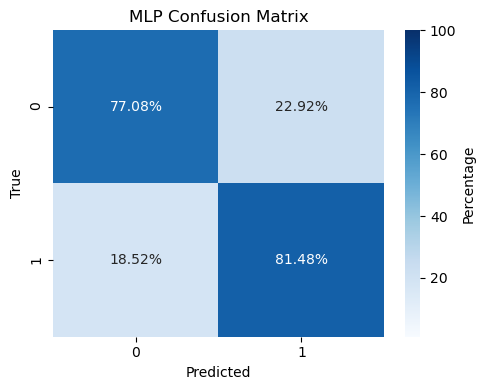

In [ ]:
# Sigmoid calibration with 10-fold StratifiedKFold (seeded)
calibrated_models = {}
for name, model in final_models.items():
    feats = list(model.feature_names_in_)
    Xr, yr = X_res[feats], y_res
    calib = CalibratedClassifierCV(
        model,
        method='sigmoid',
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    )
    calib.fit(Xr, yr)
    calibrated_models[name] = calib

# Youden full-threshold search (0–1)
print("\n===== Threshold method: YOUDEN =====")
best_thresholds = {}

for name, calib in calibrated_models.items():
    feats       = list(calibrated_models[name].estimator.feature_names_in_)
    proba_train = calib.predict_proba(X_res[feats])[:, 1]
    thrs        = np.linspace(0, 1, 101)

    best_score, best_thr = -np.inf, None
    for t in thrs:
        preds = (proba_train >= t).astype(int)
        sens  = recall_score(y_res, preds)
        tn, fp, fn, tp = confusion_matrix(y_res, preds).ravel()
        spec  = tn / (tn + fp)
        score = sens + spec - 1
        if score > best_score:
            best_score, best_thr = score, t

    best_thresholds[name] = best_thr
    print(f"{name} best threshold = {best_thr:.4f}, Youden = {best_score:.4f}")

# Report on train & test sets using the chosen thresholds
for name, calib in calibrated_models.items():
    thr   = best_thresholds[name]
    feats = list(calibrated_models[name].estimator.feature_names_in_)
    Xr    = X_res[feats]
    Xte   = X_test[feats]

    print(f"\n=== {name} (YOUDEN threshold = {thr:.4f}) ===")

    # Training set Accuracy
    p_tr     = calib.predict_proba(Xr)[:, 1]
    preds_tr = (p_tr >= thr).astype(int)
    print("Train Accuracy:", accuracy_score(y_res, preds_tr))

    # Test set Accuracy
    p_te     = calib.predict_proba(Xte)[:, 1]
    preds_te = (p_te >= thr).astype(int)
    print("Test  Accuracy:", accuracy_score(
        y_test, preds_te, sample_weight=comp_w))

    # First compute unweighted and weighted confusion matrices for later specificity
    cm_un = confusion_matrix(y_test, preds_te)
    tn_un, fp_un, fn_un, tp_un = cm_un.ravel()

    cm_w  = confusion_matrix(y_test, preds_te, sample_weight=comp_w)
    tn_w, fp_w, fn_w, tp_w     = cm_w.ravel()

    # macro, micro and weighted
    for avg in ['macro', 'micro', 'weighted']:
        if avg == 'macro':
            sw   = None
            tn, fp = tn_un, fp_un
        elif avg == 'micro':
            sw   = None
            tn, fp = tn_un, fp_un
        else:
            sw   = comp_w
            tn, fp = tn_w, fp_w

        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        prec = precision_score(
            y_test, preds_te,
            average=avg, zero_division=0,
            sample_weight=sw
        )
        rec  = recall_score(
            y_test, preds_te,
            average=avg, zero_division=0,
            sample_weight=sw
        )
        f1   = f1_score(
            y_test, preds_te,
            average=avg, zero_division=0,
            sample_weight=sw
        )
        print(f"{avg:>8} | Spec: {spec:.4f} | Prec: {prec:.4f} | "
              f"Rec: {rec:.4f} | F1: {f1:.4f}")

    # Confusion matrix
    cm_frac = cm_w / cm_w.sum(axis=1, keepdims=True)
    cm_pct  = cm_frac * 100
    cm_df   = pd.DataFrame(
        cm_pct.round(2),
        index=['True 0', 'True 1'],
        columns=['Pred 0', 'Pred 1']
    )
    print("\nConfusion Matrix (%):")
    print(cm_df.to_string())

    # Visualize heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm_pct,
        annot=cm_df.astype(str) + '%',
        fmt='',
        cmap='Blues',
        vmin=1, vmax=100,
        xticklabels=[0,1], yticklabels=[0,1],
        cbar_kws={'label':'Percentage'}
    )
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

## Model differences

In [ ]:
# using the features and thresholds obtained from the threshold search
test_preds = {}
for name, calib in calibrated_models.items():
    feats = list(calib.estimator.feature_names_in_)
    probs = calib.predict_proba(X_test[feats])[:, 1]
    thr   = best_thresholds[name]
    test_preds[name] = (probs >= thr).astype(int)

# Configuration
target = 'XGBoost'
B_perm = 10_000
B_boot = 10_000
alpha  = 0.05
rng    = np.random.default_rng(42)

# Utility functions
def weighted_accuracy(y_true, y_pred, w):
    return (w * (y_true == y_pred)).sum() / w.sum()

def cohens_h(p1, p2):
    """Cohen's h for two proportions"""
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

def bootstrap_ci(arr_diff, w, B=10000, rng=rng):
    """Bootstrap CI on pre-computed diff = correct_a − correct_b * w"""
    N = arr_diff.size
    idx = rng.integers(0, N, size=(B, N))
    boot = arr_diff[idx].sum(axis=1) / w.sum()
    lo, hi = np.percentile(boot, [2.5, 97.5])
    return lo, hi

# Preprocessing
y_true = np.asarray(y_test)
w      = np.asarray(comp_w)
correct_mask = {
    name: (preds == y_true).astype(int)
    for name, preds in test_preds.items()
}

# Statistical test + effect size + CI
rows = []
for name, preds in test_preds.items():
    if name == target:
        continue

    # Weighted accuracy
    acc_tgt = weighted_accuracy(y_true, test_preds[target], w)
    acc_cmp = weighted_accuracy(y_true, preds,             w)

    # Effect size
    delta   = acc_tgt - acc_cmp
    rel_inc = 100 * delta / acc_cmp
    h_val   = cohens_h(acc_tgt, acc_cmp)

    # Permutation p-value
    diff_vec = (correct_mask[target] - correct_mask[name])
    obs      = (diff_vec * w).sum() / w.sum()
    signs    = rng.choice([-1, 1], size=(B_perm, diff_vec.size))
    perm     = (signs * diff_vec) @ w / w.sum()
    p_raw    = (np.abs(perm) >= abs(obs)).mean()

    # Bootstrap confidence interval
    arr_diff = diff_vec * w
    ci_lo, ci_hi = bootstrap_ci(arr_diff, w, B=B_boot)

    rows.append({
        'Comparator Model'     : name,
        'Acc_target'           : acc_tgt,
        'Acc_comparator'       : acc_cmp,
        'ΔAcc'                 : delta,
        'Relative Δ (%)'       : rel_inc,
        "Cohen's h"            : h_val,
        'Raw p-value'          : p_raw,
        'CI 95% (lo)'          : ci_lo,
        'CI 95% (hi)'          : ci_hi
    })

# Multiple comparison correction (Holm)
raw_ps = [r['Raw p-value'] for r in rows]
rej, p_corr, _, _ = multipletests(raw_ps, alpha=alpha, method='holm')
for r, p_adj, sig in zip(rows, p_corr, rej):
    r['Holm-adj p']      = p_adj
    r['Significant (α)'] = 'Yes' if sig else 'No'

# Output table
cols = ['Comparator Model', 'Acc_target', 'Acc_comparator',
        'ΔAcc', 'Relative Δ (%)', "Cohen's h",
        'Raw p-value', 'Holm-adj p', 'CI 95% (lo)', 'CI 95% (hi)',
        'Significant (α)']
df_stats = pd.DataFrame(rows)[cols]

print("\n=== Pairwise Results (XGBoost vs Others) ===")
print(df_stats.to_string(index=False, float_format=lambda x: f"{x:.4f}"))


=== Pairwise Results (XGBoost vs Others) ===
Comparator Model  Acc_target  Acc_comparator   ΔAcc  Relative Δ (%)  Cohen's h  Raw p-value  Holm-adj p  CI 95% (lo)  CI 95% (hi) Significant (α)
    RandomForest      0.8125          0.7918 0.0208          2.6243     0.0522       0.4795      0.9462      -0.0318       0.0796              No
             SVM      0.8125          0.7954 0.0172          2.1609     0.0433       0.4013      0.9462      -0.0209       0.0555              No
        LightGBM      0.8125          0.7087 0.1038         14.6524     0.2447       0.0030      0.0150       0.0370       0.1823             Yes
             KNN      0.8125          0.7763 0.0362          4.6625     0.0897       0.1552      0.6208      -0.0150       0.0849              No
             MLP      0.8125          0.7945 0.0181          2.2730     0.0455       0.3154      0.9462      -0.0168       0.0491              No


## ROC & PR curves

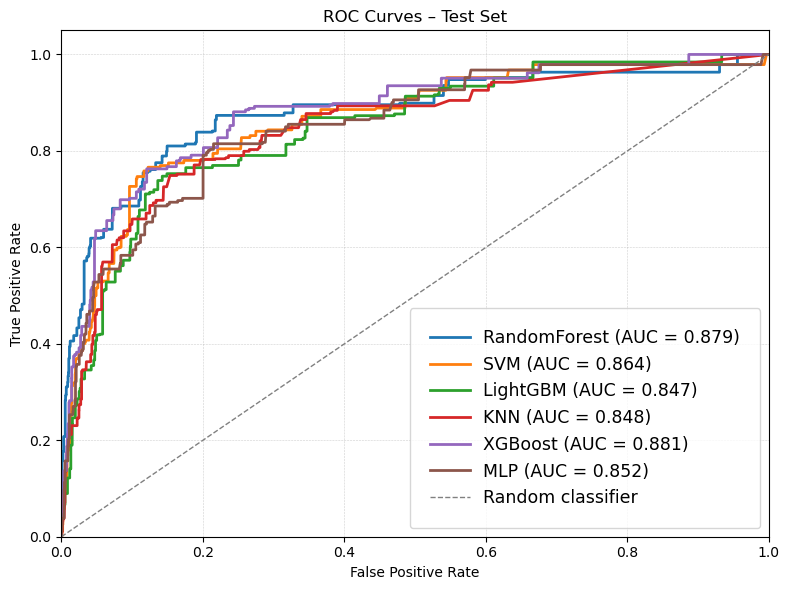

In [ ]:
plt.figure(figsize=(8, 6))

for name, calib in calibrated_models.items():
    # Fetch feature names directly from final_models
    feats      = list(final_models[name].feature_names_in_)
    Xte        = X_test[feats]
    # Compute probabilities with calibrated model
    y_score    = calib.predict_proba(Xte)[:, 1]

    # Plot weighted ROC using composite weights
    fpr, tpr, _    = roc_curve(y_test, y_score, sample_weight=comp_w)
    roc_auc_val    = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f"{name} (AUC = {roc_auc_val:.3f})")
plt.plot(
    [0, 1], [0, 1],
    ls='--', color='gray', lw=1,
    label='Random classifier'        
)
plt.legend(
    loc='lower right',
    fontsize=12.5,       
    markerscale=1.5,  
    handlelength=2.25,    
    handletextpad=0.75, 
    borderpad=1.2,     
    labelspacing=0.5   
)

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Test Set")
plt.grid(linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()

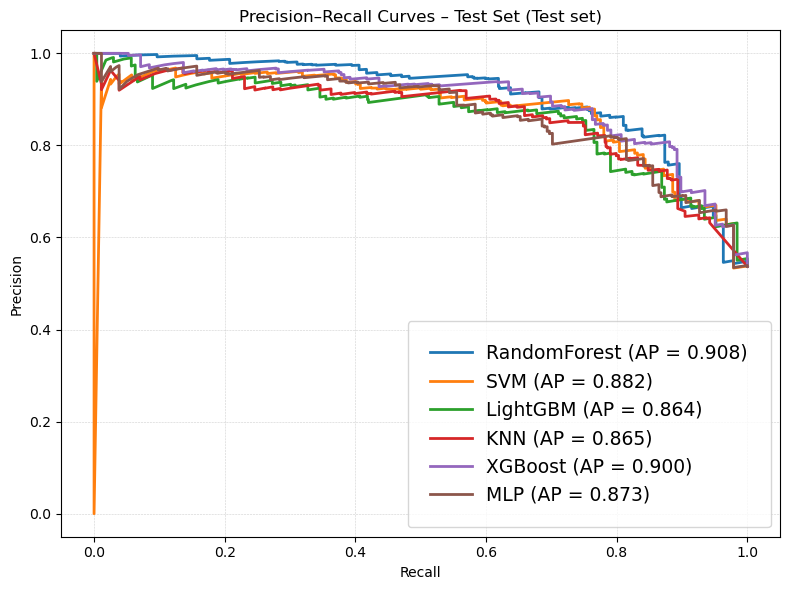

In [ ]:
plt.figure(figsize=(8, 6))

for name, calib in calibrated_models.items():
    # Feature selection
    feats   = list(final_models[name].feature_names_in_)
    Xte     = X_test[feats]

    # Predict calibrated probabilities
    y_score = calib.predict_proba(Xte)[:, 1]

    # Compute weighted Precision–Recall
    precision, recall, _ = precision_recall_curve(
        y_test,
        y_score,
        sample_weight=comp_w
    )
    ap_score = average_precision_score(
        y_test,
        y_score,
        sample_weight=comp_w
    )

    # Plot
    plt.plot(recall, precision, lw=2,
             label=f"{name} (AP = {ap_score:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Test Set (Test set)")
plt.legend(
    loc='lower right',
    fontsize=13.5,
    markerscale=1.6,
    handlelength=2.25,
    handletextpad=0.75,
    borderpad=1.2,
    labelspacing=0.5
)

plt.grid(linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()

## Feature Importance

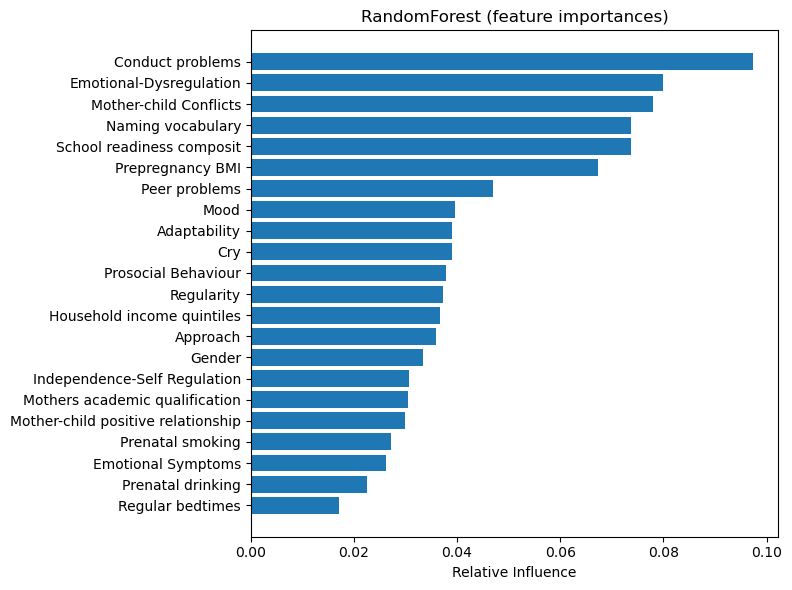

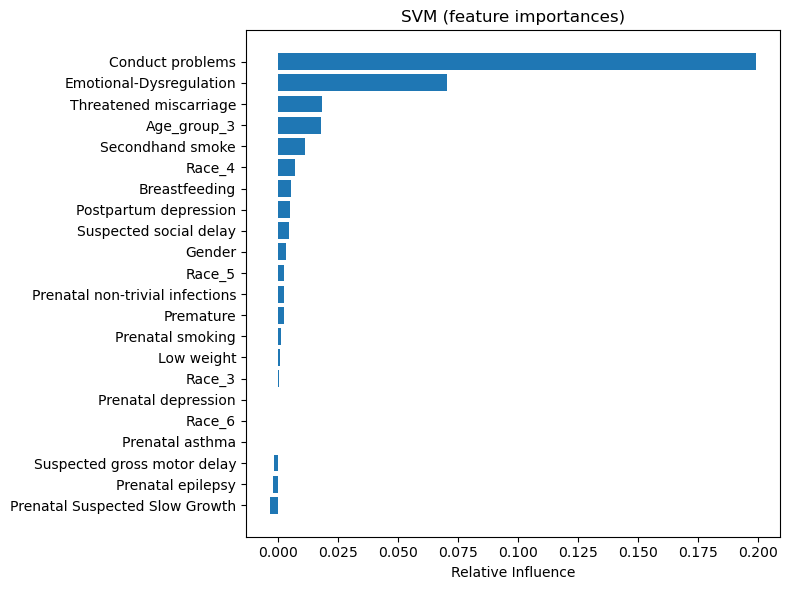

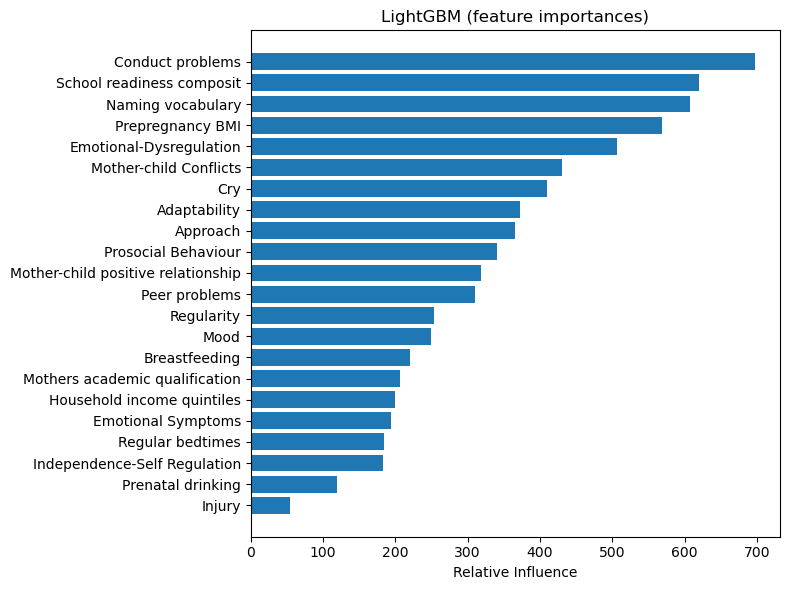

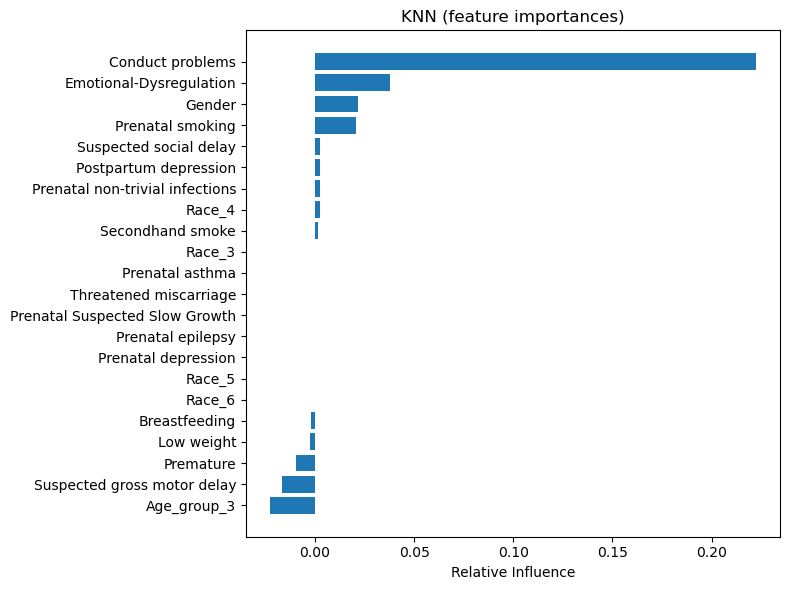

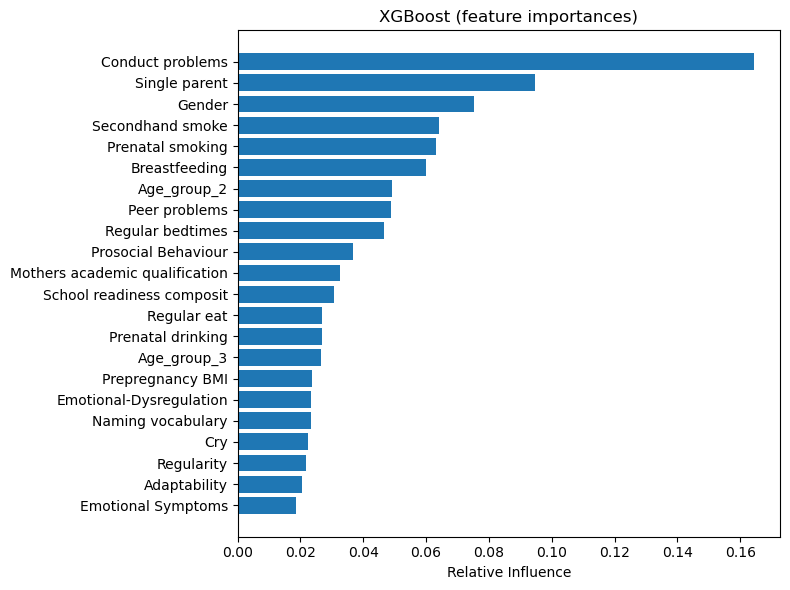

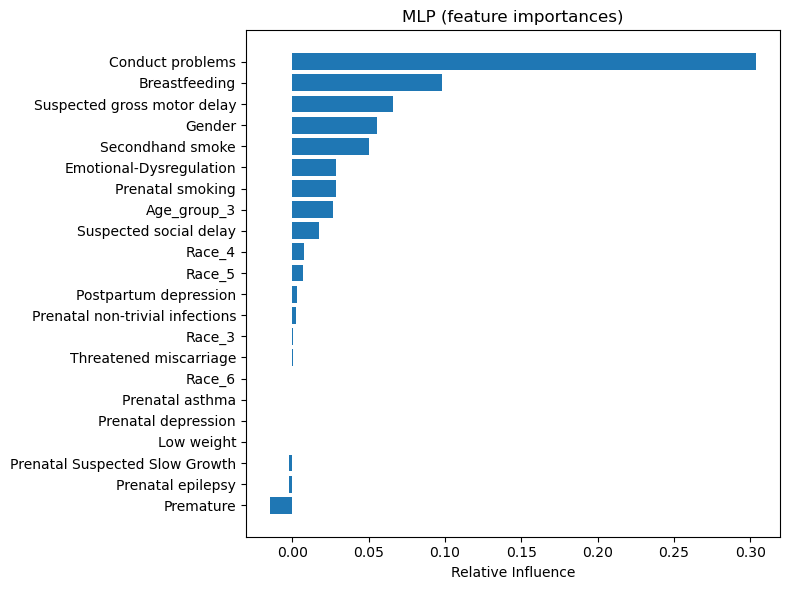

In [ ]:
for name, model in final_models.items():
    feats = list(model.feature_names_in_)
    
    # Perform an 80/20 stratified split on X_res[feats], y_res
    X_tr_feat, X_val_feat, y_tr_feat, y_val_feat = train_test_split(
        X_res[feats], 
        y_res, 
        stratify=y_res, 
        test_size=0.2, 
        random_state=42
    )
    
    # Compute class weights for the validation set and construct a weighted accuracy scorer
    class_w_val   = pd.Series(y_val_feat, index=y_val_feat.index) \
                         .map(class_weights).fillna(1.0)
    weighted_acc  = make_scorer(accuracy_score, sample_weight=class_w_val)
    
    # Extract feature importances
    if hasattr(model, 'feature_importances_'):
        # Tree-based models: use built-in feature importances
        importances = model.feature_importances_
        source = 'feature importances'
    else:
        # Non-tree-based models (e.g., SVM): compute weighted permutation importance on the validation set
        result = permutation_importance(
            model,
            X_val_feat,
            y_val_feat,
            scoring=weighted_acc,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importances = result.importances_mean
    
    # Sort importances and plot
    idx_sorted   = np.argsort(importances)[::-1]
    sorted_feats = np.array(feats)[idx_sorted]
    sorted_imp   = importances[idx_sorted]
    
    plt.figure(figsize=(8, 6))
    plt.barh(sorted_feats, sorted_imp)
    plt.gca().invert_yaxis()
    plt.title(f"{name} {source}")
    plt.xlabel("Relative Influence")
    plt.tight_layout()
    plt.show()

## Sensitivity Analysis: Between-Group Correlation + 10-Fold Permutation Results

In [ ]:
desired_prenatal_new = [
    'Premature', 'Low weight', 'Prenatal depression', 'Prenatal eclampsia', 'Prenatal epilepsy',
    'Prenatal Suspected Slow Growth', 'Multiple pregnancy', 'Threatened miscarriage', 'Prenatal asthma',
    'Prenatal persistent vomiting', 'Prenatal non-trivial infections', 'Prenatal smoking', 'Prenatal drinking',
    'Age_group_2', 'Age_group_3', 'Age_group_4', 'Prepregnancy BMI'
]
desired_postnatal_new = [
    'Mother-child Conflicts', 'Mother-child positive relationship', 'Breastfeeding', 'Postpartum depression',
    'Regular bedtimes', 'Regular eat', 'Single parent', 'Media', 'Injury',
    'Secondhand smoke', 'Suspected social delay', 'Suspected fine motor delay',
    'Suspected gross motor delay', 'Mood', 'Approach', 'Adaptability',
    'Regularity', 'Cry', 'Naming vocabulary', 'School readiness composit', 'Independence-Self Regulation',
    'Emotional-Dysregulation', 'Emotional Symptoms', 'Conduct problems', 'Peer problems', 'Prosocial Behaviour'
]
# Compute and flatten the absolute correlation matrix between prenatal and postnatal features
corr_mat = (
    df_corr[prenatal_cols + postnatal_cols]
      .corr()
      .loc[prenatal_cols, postnatal_cols]
      .abs()
)
vals = corr_mat.values.flatten()

print(pd.Series(vals, name='|ρ|').describe())

count    442.000000
mean       0.030137
std        0.036953
min        0.000019
25%        0.007107
50%        0.018214
75%        0.037301
max        0.340753
Name: |ρ|, dtype: float64


In [ ]:
# Feature grouping
models_to_compare = ['XGBoost', 'SVM']
feature_groups = {
    'XGBoost': {
        'prenatal':  ['Age_group_2','Prenatal smoking','Age_group_3','Prepregnancy BMI','Prenatal drinking'],
        'postnatal': ['Conduct problems','Peer problems','Prosocial Behaviour','School readiness composit',
                      'Emotional-Dysregulation','Naming vocabulary','Cry','Regularity','Adaptability','Approach',
                      'Breastfeeding','Single parent','Regular bedtimes','Regular eat','Secondhand smoke'],
        'demographic':['Gender','Mothers academic qualification']
    },
    'SVM': {
        'prenatal':  ['Threatened miscarriage','Prenatal non-trivial infections','Premature','Low weight',
                      'Prenatal smoking','Age_group_3','Prenatal depression','Prenatal asthma','Prenatal epilepsy',
                      'Prenatal Suspected Slow Growth'],
        'postnatal': ['Conduct problems','Emotional-Dysregulation','Secondhand smoke','Breastfeeding',
                      'Postpartum depression','Suspected social delay','Suspected gross motor delay'],
        'demographic':['Race_3','Race_4','Race_5','Race_6','Gender']
    }
}

# Extract selected features after RFE for each model
feats_dict = {
    name: list(final_models[name].feature_names_in_)
    for name in models_to_compare
}

# 10-fold cross-validation sensitivity analysis
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = []

for name in models_to_compare:
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        feats = feats_dict[name]
        X_tr, y_tr = X.iloc[train_idx][feats], y.iloc[train_idx]
        X_te, y_te = X.iloc[test_idx][feats], y.iloc[test_idx]

        model = clone(final_models[name])
        model.fit(X_tr, y_tr)

        # baseline AUC
        auc0 = roc_auc_score(y_te, model.predict_proba(X_te)[:,1])

        # permutation by feature group
        for grp, cols in feature_groups[name].items():
            grp_feats = [c for c in cols if c in feats]
            if not grp_feats:
                continue

            Xp = X_te.copy()
            Xp[grp_feats] = X_te[grp_feats].sample(frac=1.0, random_state=fold).to_numpy()
            aucp = roc_auc_score(y_te, model.predict_proba(Xp)[:,1])

            cv_results.append({
                'model': name,
                'fold': fold,
                'group': grp,
                'delta_auc': auc0 - aucp
            })

# Summarize mean ± SD of ΔAUC and one-sided t-test p-values
df_cv = pd.DataFrame(cv_results)
grouped = df_cv.groupby(['model','group'])['delta_auc']
summary = grouped.agg(['mean','std']).round(4)
summary['p_value'] = grouped.apply(
    lambda x: ttest_1samp(x, 0, alternative='greater').pvalue
).round(4)

print("\n10-fold CV ΔAUC mean ± std & one-sided t-test p-value:")
print(summary.unstack(level=1))

d:\Anaconda3\envs\oldml39\lib\site-packages\xgboost\core.py:158: UserWarning: [16:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32592\3393087972.py:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Xp.loc[:, grp_feats] = permuted
C:\Users\Administrator\AppData\Local\Temp\ipykernel_32592\3393087972.py:59: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if co


10-fold CV ΔAUC mean ± std & one-sided t-test p-value:
               mean                            std                     \
group   demographic postnatal prenatal demographic postnatal prenatal   
model                                                                   
SVM          0.0525    0.1756   0.0274      0.0290    0.0316   0.0194   
XGBoost      0.0496    0.2440   0.0129      0.0326    0.0653   0.0228   

            p_value                     
group   demographic postnatal prenatal  
model                                   
SVM          0.0001       0.0   0.0008  
XGBoost      0.0005       0.0   0.0536  


## SHAP analysis

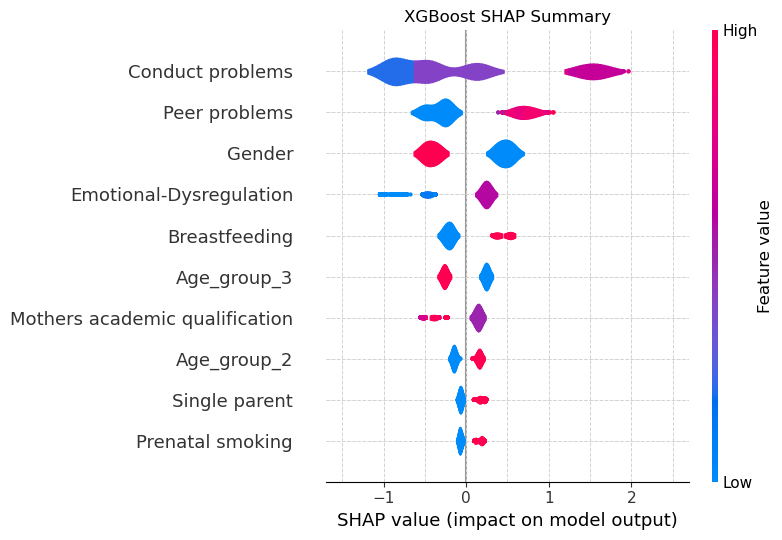

In [ ]:
# Unscale continuous columns
X_test_unscaled = X_test.copy()
X_test_unscaled[val_cols] = scaler.inverse_transform(X_test[val_cols])

# Construct SHAP input matrix
xgb_model  = final_models['XGBoost']
feat_names = list(xgb_model.feature_names_in_)
X_sel      = X_test_unscaled[feat_names].reset_index(drop=True)
n_samples, n_feat = X_sel.shape

# Define replicate
def replicate(arr, Xdf, weights, max_copy=10):
    w = np.asarray(weights) / np.min(weights)
    copies = np.clip(np.round(np.sqrt(w)), 1, max_copy).astype(int)
    idx = np.repeat(np.arange(len(w)), copies)
    return arr[idx], Xdf.iloc[idx].reset_index(drop=True)

# Tree Explainer
bg = shap.sample(X_sel, 100, random_state=42)
explainer_main = shap.TreeExplainer(
    xgb_model,
    data=bg,
    feature_perturbation="interventional",
    model_output="raw"
)
sh_exp  = explainer_main(X_sel)
sh_vals = sh_exp.values
if sh_vals.ndim == 3:
    sh_vals = sh_vals[:, 1, :] 

# Plot weighted SHAP main effect violin plot for the top 10 features
sh_rep_full, X_rep_full = replicate(sh_vals, X_sel, comp_w, max_copy=10)
shap.summary_plot(
    sh_rep_full,
    X_rep_full,
    feature_names=feat_names,
    plot_type="violin",
    max_display=10, 
    show=False
)
ax = plt.gca()
ax.grid(False)
for x in ax.get_xticks():
    ax.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.7, zorder=0)
for y in ax.get_yticks():
    ax.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.7, zorder=0)
plt.title("XGBoost SHAP Summary")
plt.tight_layout()
plt.show()

## Sensitivity Analysis: Univariate Logistic Regression & SHAP anlysis without Sampling Weights

In [13]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
clf = LogisticRegression(solver='liblinear')
X_train_uni = X_train[['Academic']]
X_test_uni  = X_test[['Academic']]
clf.fit(X_train_uni, y_train)
coef = clf.coef_[0][0]
odds_ratio = np.exp(coef)

print("=== Scikit-learn univariate Logistic Regression ===")
print(f"Coefficient for Academic: {coef:.4f}")
print(f"Odds Ratio for Academic: {odds_ratio:.4f}")

# 4.2 Use statsmodels to get detailed summary
X_train_sm  = sm.add_constant(X_train_uni)
logit_model = sm.Logit(y_train, X_train_sm)
result      = logit_model.fit(disp=False)

print("\n=== Statsmodels univariate Logistic Regression summary ===")
print(result.summary())

=== Scikit-learn univariate Logistic Regression ===
Coefficient for Academic: 0.1045
Odds Ratio for Academic: 1.1102

=== Statsmodels univariate Logistic Regression summary ===
                           Logit Regression Results                           
Dep. Variable:             Early_ADHD   No. Observations:                 6569
Model:                          Logit   Df Residuals:                     6567
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Jul 2025   Pseudo R-squ.:                0.006968
Time:                        16:37:52   Log-Likelihood:                -822.79
converged:                       True   LL-Null:                       -828.57
Covariance Type:            nonrobust   LLR p-value:                 0.0006789
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0723      0.176 

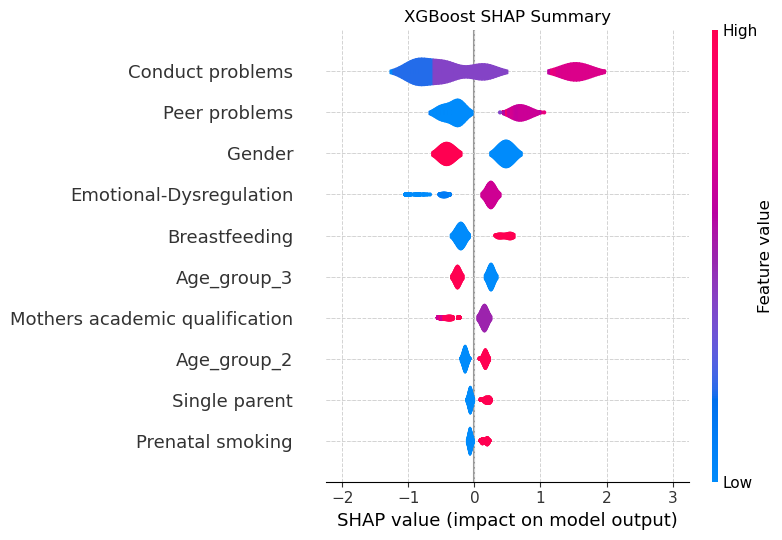

In [ ]:
# Unscale continuous columns
X_test_unscaled = X_test.copy()
X_test_unscaled[val_cols] = scaler.inverse_transform(X_test[val_cols])

# Construct SHAP input matrix
xgb_model  = final_models['XGBoost']
feat_names = list(xgb_model.feature_names_in_)
X_sel      = X_test_unscaled[feat_names].reset_index(drop=True)
n_samples, n_feat = X_sel.shape

# Define replicate
def replicate(arr, Xdf, weights, max_copy=10):
    w = np.asarray(weights) / np.min(weights)
    copies = np.clip(np.round(np.sqrt(w)), 1, max_copy).astype(int)
    idx = np.repeat(np.arange(len(w)), copies)
    return arr[idx], Xdf.iloc[idx].reset_index(drop=True)

# Tree Explainer
bg = shap.sample(X_sel, 100, random_state=42)
explainer_main = shap.TreeExplainer(
    xgb_model,
    data=bg,
    feature_perturbation="interventional",
    model_output="raw"
)
sh_exp  = explainer_main(X_sel)
sh_vals = sh_exp.values
if sh_vals.ndim == 3:
    sh_vals = sh_vals[:, 1, :] 

# Plot weighted SHAP main effect violin plot for the top 10 features
sh_rep_full, X_rep_full = replicate(sh_vals, X_sel, class_weights, max_copy=10)
shap.summary_plot(
    sh_rep_full,
    X_rep_full,
    feature_names=feat_names,
    plot_type="violin",
    max_display=10, 
    show=False
)
ax = plt.gca()
ax.grid(False)
for x in ax.get_xticks():
    ax.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.7, zorder=0)
for y in ax.get_yticks():
    ax.axhline(y=y, color='lightgray', linestyle='--', linewidth=0.7, zorder=0)
plt.title("XGBoost SHAP Summary")
plt.tight_layout()
plt.show()

## Proportion of each domain based on SHAP values

C:\Users\Administrator\AppData\Local\Temp\ipykernel_32592\358695658.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mean_abs_phi = (np.abs(sh_vals) * comp_w[:, None]).sum(axis=0) / comp_w.sum()


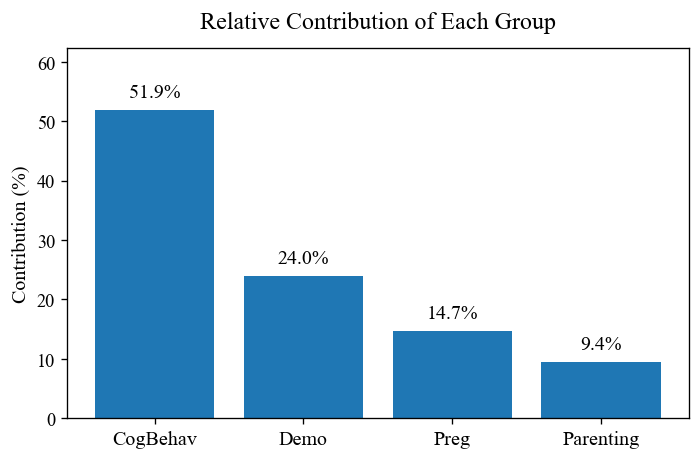

In [ ]:
# Compute weighted average absolute SHAP for all features
mean_abs_phi = (np.abs(sh_vals) * comp_w[:, None]).sum(axis=0) / comp_w.sum()

# Specify the top ten new label features
top10 = [
    'Conduct problems','Peer problems','Gender',
    'Emotional-Dysregulation','Breastfeeding','Age_group_3',
    'Mothers academic qualification','Age_group_2','Prenatal smoking',
    'Single parent'
]

# Define four groups for these ten features (new labels)
groups = {
    'CogBehav' : ['Conduct problems','Peer problems','Emotional-Dysregulation'],
    'Demo'     : ['Gender','Mothers academic qualification'],
    'Preg'     : ['Age_group_2','Age_group_3','Prenatal smoking'],
    'Parenting': ['Breastfeeding', 'Single parent']
}

# Aggregate each group's contribution in top10
group_vals = {}
for g, members in groups.items():
    s = 0.0
    for f in members:
        if f in top10:
            idx = feat_names.index(f)
            s += mean_abs_phi[idx]
    group_vals[g] = s

# Construct DataFrame and calculate percentage contributions
df_main = pd.DataFrame({
    'Group'       : list(group_vals.keys()),
    'Contribution': list(group_vals.values())
})
df_main['Pct_contrib'] = (df_main['Contribution'] / df_main['Contribution'].sum() * 100).round(1)
df_main = df_main.sort_values('Pct_contrib', ascending=False).reset_index(drop=True)

# Style settings
plt.rcParams.clear()
plt.rcParams['font.family']   = 'Times New Roman'
plt.rcParams['font.size']     = 12
plt.rcParams['figure.dpi']    = 120
plt.rcParams['axes.titlepad'] = 12

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_main['Group'], df_main['Pct_contrib'], edgecolor='none')
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 1.5,
        f"{h:.1f}%",
        ha='center', va='bottom',
        fontfamily='Times New Roman'
    )

ax.set_title('Relative Contribution of Each domain',
             fontfamily='Times New Roman')
ax.set_ylabel('Contribution (%)',
              fontfamily='Times New Roman')
ax.set_xticks(range(len(df_main)))
ax.set_xticklabels(df_main['Group'],
                   rotation=0,
                   fontfamily='Times New Roman')
ax.set_ylim(0, df_main['Pct_contrib'].max() * 1.2)  # automatic padding
ax.yaxis.set_tick_params(labelsize=11)
fig.subplots_adjust(top=0.90)
plt.tight_layout()
plt.show()

## Proportion of the top 10 features in the model according to SHAP analysis

In [21]:
# Take absolute values and compute mean across feature dimension
abs_shap      = np.abs(sh_vals)                                  
mean_abs_shap = np.mean(abs_shap, axis=0)                        

# Create a Series with feature names and sort descending
feat_imp = pd.Series(mean_abs_shap, index=feat_names).sort_values(ascending=False)

# Sum importance of top 10 features
top10_sum  = feat_imp.iloc[:10].sum()
total_sum  = feat_imp.sum()

# Compute and print ratio
ratio = top10_sum / total_sum
print(f"SHAP contribution ratio of top 10 features: {ratio:.2%}")

SHAP contribution ratio of top 10 features: 90.99%


## Local feature-value impacts of SHAP analysis

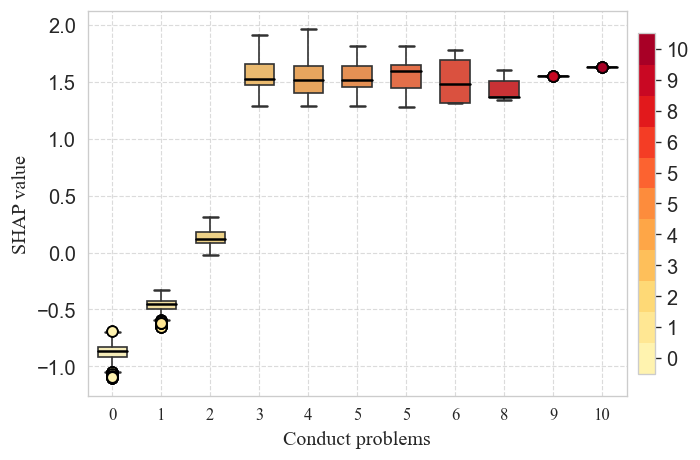

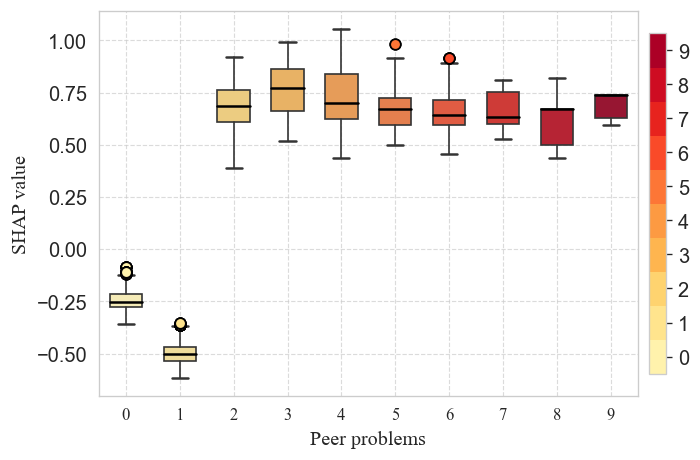

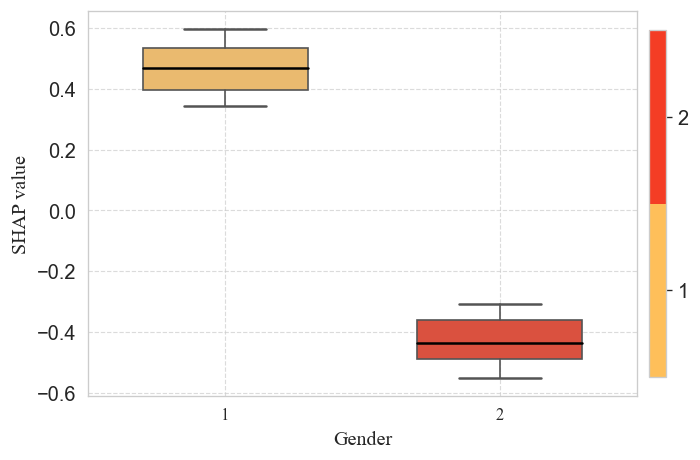

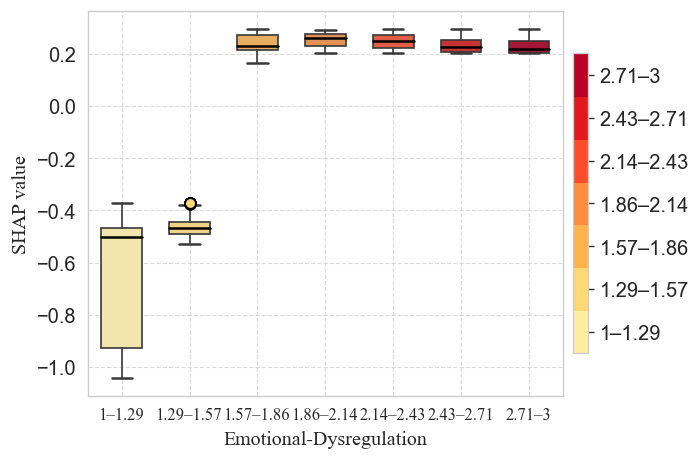

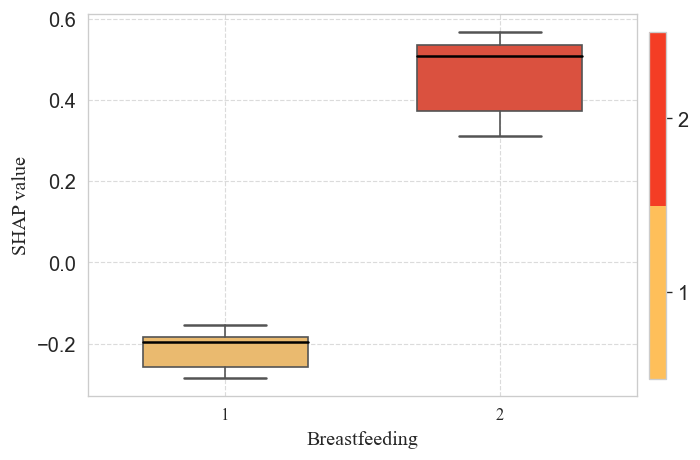

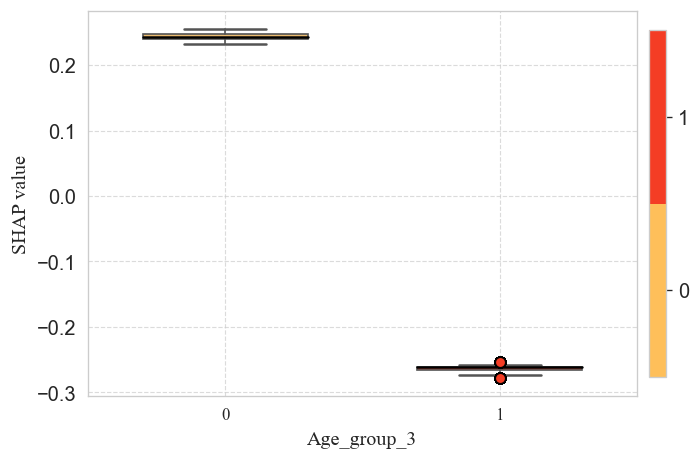

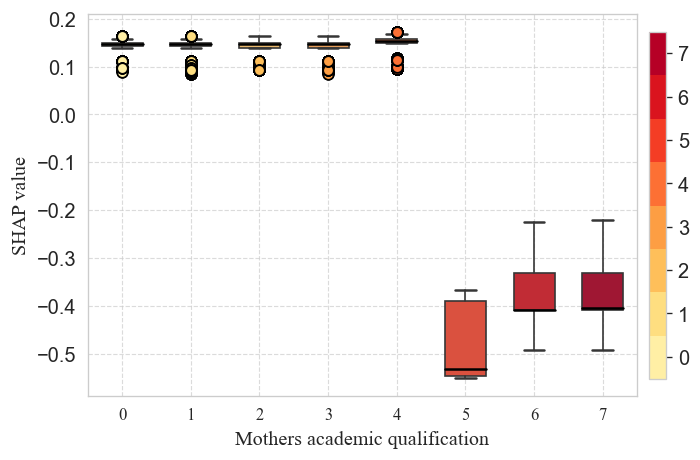

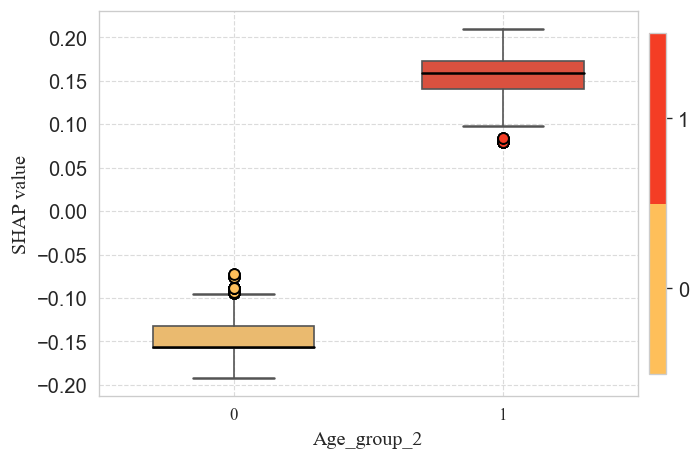

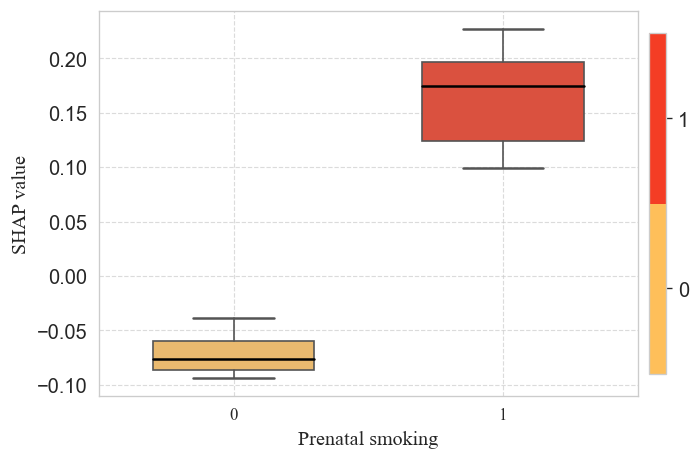

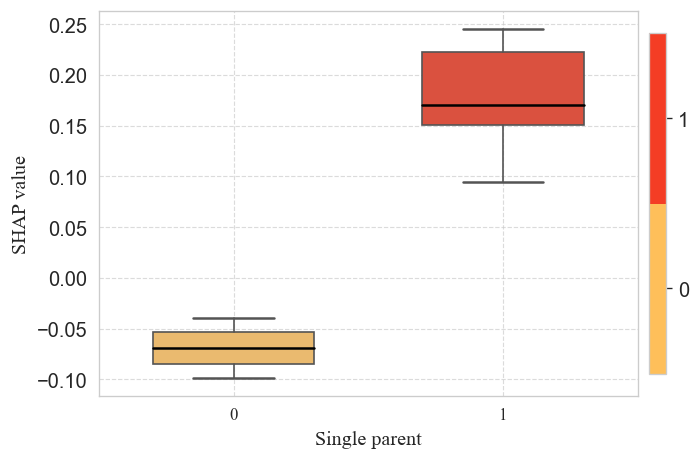

In [ ]:
#  Define replicate
def replicate(arr, bins, weights, max_copy=10):
    w = np.asarray(weights) / np.min(weights)
    copies = np.clip(np.round(np.sqrt(w)), 1, max_copy).astype(int)
    idx = np.repeat(np.arange(len(w)), copies)
    return arr[idx], bins[idx]

top10 = [
    'Conduct problems','Peer problems','Gender',
    'Emotional-Dysregulation','Breastfeeding','Age_group_3',
    'Mothers academic qualification','Age_group_2','Prenatal smoking',
    'Single parent'
]
continuous_feats = ['Emotional-Dysregulation']

def fmt(x):
    x = float(x)
    return str(int(round(x))) if abs(x - round(x)) < 1e-6 else f"{round(x,2)}"

# Binning & Labels
binned, bin_labels = {}, {}
for f in top10:
    if f in continuous_feats:
        arr = X_sel[f].astype(float).values
        edges = np.linspace(arr.min(), arr.max(), 8)
        cats = pd.cut(arr, bins=edges, labels=False,
                      include_lowest=True, right=True).astype(int)
        binned[f] = cats
        bin_labels[f] = [
            fmt(edges[i]) + "–" + fmt(edges[i+1])
            for i in range(len(edges)-1)
        ]
    else:
        vals = sorted(pd.unique(X_sel[f]))
        int_vals = [int(v) for v in vals]
        mapping = {v:i for i,v in enumerate(vals)}
        binned[f] = X_sel[f].map(mapping).astype(int)
        bin_labels[f] = [str(v) for v in int_vals]

sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Plotting loop
for feat in top10:
    # Original bins & shap
    orig_bins = binned[feat]
    orig_shap = shap_df[feat].values

    # Replicate using composite weights
    rep_shap, rep_bins = replicate(orig_shap, orig_bins, comp_w, max_copy=10)

    df = pd.DataFrame({
        'bin': rep_bins,
        'shap': rep_shap
    })

    # Fill empty bins for continuous features
    if feat in continuous_feats:
        n_bins = len(bin_labels[feat])
        missing = set(range(n_bins)) - set(df['bin'].dropna().unique())
        if missing:
            pad = pd.DataFrame({
                'bin': list(missing),
                'shap': [np.nan]*len(missing)
            })
            df = pd.concat([df, pad], ignore_index=True)

    order  = list(range(len(bin_labels[feat])))
    labels = bin_labels[feat]

    palette = sns.color_palette("YlOrRd", n_colors=len(order))
    cmap    = mpl.colors.ListedColormap(palette)
    norm    = mpl.colors.BoundaryNorm(np.arange(len(order)+1)-0.5, cmap.N)

    fig, ax = plt.subplots(figsize=(6,4))

    sns.boxplot(
        x='bin', y='shap', data=df,
        order=order, palette=palette,
        showcaps=True, showfliers=False,
        boxprops={'linewidth':1},
        whiskerprops={'linewidth':1},
        medianprops={'color':'black'},
        width=0.6, ax=ax, zorder=1
    )

    for b in order:
        grp = df[df['bin']==b]
        if grp.empty: continue
        if len(grp)==1:
            ax.scatter(
                b, grp['shap'].iat[0],
                color=palette[b], edgecolors='black',
                s=60, zorder=2
            ); continue
        q1,q3 = grp['shap'].quantile([.25,.75])
        iqr    = q3 - q1
        if np.isclose(iqr,0):
            xs = np.full(len(grp), b, dtype=float)
            ax.scatter(xs, grp['shap'].values,
                       color=palette[b], edgecolors='black',
                       s=40, alpha=0.8, zorder=2)
            continue
        lower, upper = q1-1.5*iqr, q3+1.5*iqr
        fl = grp[(grp['shap']<lower)|(grp['shap']>upper)]
        if not fl.empty:
            xs = np.full(len(fl), b, dtype=float)
            ax.scatter(xs, fl['shap'],
                       color=palette[b], edgecolors='black',
                       s=40, zorder=2)

    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.7, zorder=0)
    ax.set_xticks(order)
    ax.set_xticklabels(
        labels, rotation=0, ha='center',
        fontfamily='Times New Roman', fontsize=10
    )
    ax.set_xlabel(feat,
                  fontfamily='Times New Roman', fontsize=12)
    ax.set_ylabel("SHAP value",
                  fontfamily='Times New Roman', fontsize=12)

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, ticks=order, fraction=0.03, pad=0.02)
    cbar.set_ticklabels(labels)
    cbar.ax.tick_params(labelrotation=0, labelsize=10)

    plt.tight_layout()
    plt.show()

## Tuned hyper-parameters for six machine-learning

In [23]:
# — Print full parameter list for each model —
def print_full_params(name, mdl):
    print(f'\n=== {name}: Complete parameter list ===')
    params = mdl.get_params()
    for k, v in params.items():
        print(f'{k}: {v}')

# — Display and export as DataFrame (optional) —
def export_params_table(models_dict, load_dir='.'):
    df = pd.DataFrame.from_dict(
        {name: mdl.get_params() for name, mdl in models_dict.items()},
        orient='index'
    )
    # Disable column truncation and adjust display width
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    print('\n=== Preview of all model parameters table ===')
    print(df)

# Prepare models container
if isinstance(final_models, dict):
    models = final_models
elif isinstance(final_models, (list, tuple)):
    models = {f'Model_{i}': m for i, m in enumerate(final_models)}
else:
    models = {'Model_0': final_models}

# Output per model (only full parameters)
for name, mdl in models.items():
    print_full_params(name, mdl)


=== RandomForest: Complete parameter list ===
bootstrap: True
ccp_alpha: 0.0
class_weight: {0: 0.514167188478397, 1: 18.146408839779006}
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 5
min_samples_split: 15
min_weight_fraction_leaf: 0.0
n_estimators: 800
n_jobs: 1
oob_score: False
random_state: 42
verbose: 0
warm_start: False

=== SVM: Complete parameter list ===
C: 1000
break_ties: False
cache_size: 200
class_weight: balanced
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: 0.0001
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 1e-06
verbose: False

=== LightGBM: Complete parameter list ===
boosting_type: gbdt
class_weight: {0: 0.514167188478397, 1: 18.146408839779006}
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.01
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 200
n_jobs: 1
num_leaves: 63
ob